In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Collect Data

In [3]:
# Creating a Dataset
np.random.seed(555)

X1= np.random.normal(100,15,200).astype(int)
X2= np.random.normal(10,4.5,200)
X3=np.random.normal(32,4,200).astype(int)
dob=np.datetime64('2017-10-31')-365*X3         
b=5
er=np.random.normal(0,1.5,200)

Y= np.array([0.3*x1+1.5*x2+0.83*x3+b+e for x1,x2,x3,e in zip(X1,X2,X3,er)])

In [4]:
dob[:5]

array(['1994-11-06', '1992-11-06', '1988-11-07', '1984-11-08',
       '1981-11-09'], dtype='datetime64[D]')

In [5]:
X1[:5]

array([102, 105,  83, 103,  97])

In [6]:
X2[:5]

array([ 3.13466597, 15.2453711 ,  2.39108351,  9.60672057, 11.13461909])

In [7]:
er[:5]

array([-0.72614499, -1.12823355,  0.00768172, -1.91621397,  1.86516392])

# Data Cleaning

In [8]:
cols=['iq','years_experience','dob']
df =DF(list(zip(X1,X2,dob)),columns=cols)
df['income']=Y

In [9]:
df.head()

,iq,years_experience,dob,income
0,102,3.134666,1994-11-06,58.665854
1,105,15.245371,1992-11-06,78.989823
2,83,2.391084,1988-11-07,57.564307
3,103,9.606721,1984-11-08,75.783867
4,97,11.134619,1981-11-09,82.547093


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
iq                  200 non-null int64
years_experience    200 non-null float64
dob                 200 non-null datetime64[ns]
income              200 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 6.3 KB


In [11]:
df.describe()

,iq,years_experience,income
count,200.000000,200.000000,200.000000
mean,98.895000,9.708405,75.177962
std,14.991253,4.654536,8.889551
min,62.000000,-5.789565,49.467100
25%,88.500000,6.603565,69.391361
50%,99.000000,10.021919,75.180707
75%,108.250000,12.927809,80.739804
max,134.000000,21.889216,98.380710


In [12]:
df =df[df.years_experience >=0]
df.describe()

,iq,years_experience,income
count,196.000000,196.000000,196.000000
mean,98.959184,9.963718,75.603845
std,14.769628,4.332578,8.424493
min,62.000000,0.084480,54.325402
25%,88.500000,6.940314,69.619532
50%,99.000000,10.192384,75.327426
75%,108.250000,12.967590,80.798796
max,134.000000,21.889216,98.380710


# EDA

In [13]:
df.describe(include=['datetime64'])

,dob
count,196
unique,22
top,1986-11-08 00:00:00
freq,20
first,1975-11-11 00:00:00
last,1996-11-05 00:00:00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124377470>,
      dtype=object)

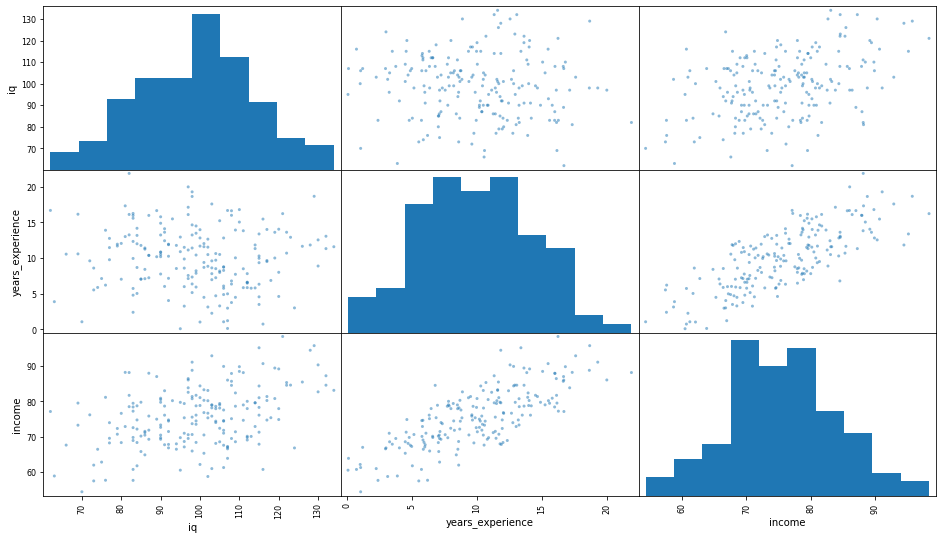

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

pd.plotting.scatter_matrix(df,figsize=(16,9))

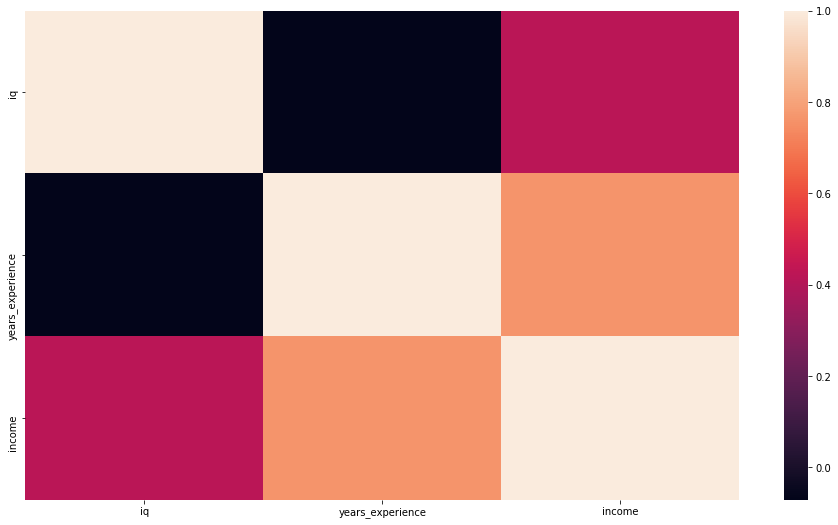

In [15]:
import seaborn as sns
plt.figure(figsize=(16,9))
sns.heatmap(df.corr())

# Data Processing/ Feature Engineering

In [16]:
from datetime import datetime as dt

df['age']=df.dob.apply(lambda x: (dt.strptime('2017-10-31','%Y-%m-%d')-x).days/365)
df.drop('dob',axis=1,inplace=True)
df.head()

,iq,years_experience,income,age
0,102,3.134666,58.665854,23.0
1,105,15.245371,78.989823,25.0
2,83,2.391084,57.564307,29.0
3,103,9.606721,75.783867,33.0
4,97,11.134619,82.547093,36.0


# Train/Evaluate Model

In [17]:

X=df.iloc[:,[0,1,3]]
Y=df.income

tr_idx= X.sample(frac=0.67).index
Xtr =X[X.index.isin(tr_idx)].values
Xta=X[~X.index.isin(tr_idx)].values

Ytr =Y[Y.index.isin(tr_idx)].values
Yta=Y[~Y.index.isin(tr_idx)].values

# Create Model

### Getting Tesnsorboard summaries

- create summaries
- merge summaries
- create a summary writer
- run merged summaries with model in a session
- use writer to write the output

In [18]:

tf.reset_default_graph()

In [19]:
sess=tf.Session()
w = tf.get_variable(name='w',initializer=[[0.1],[0.1],[0.1]])
tf.summary.scalar('wmean',tf.reduce_mean(w))
tf.summary.scalar('wsum',tf.reduce_sum(w))
tf.summary.histogram('weights',w)

b= tf.get_variable(name='b',initializer=0.)
tf.summary.histogram('intercept',b)

x=tf.placeholder('float32',name='x')
y=tf.placeholder('float32',name='y_true')

yhat =tf.reshape(tf.matmul(x,w)+b,[-1,],name='yhat')

Instructions for updating:
Colocations handled automatically by placer.


# Create the loss and test score functions

In [20]:
mse=tf.reduce_mean(tf.square(y - yhat),name='mse')
rmse =tf.sqrt(mse,name='rmse')
tf.summary.scalar('loss_rmse',rmse)

#test_score
test_nrmse =tf.divide(rmse,tf.abs(tf.reduce_mean(y)),name='nrmse')
tf.summary.scalar('test_nrmse',test_nrmse)

#merge all sumarries a create a writer object that will write during training
summaries= tf.summary.merge_all()
writer = tf.summary.FileWriter(logdir='/tmp/linear_logs',graph=sess.graph)

In [21]:
init =tf.variables_initializer([w,b])
sess.run(init)

# Training/Evaluation

In [22]:
opt=tf.train.GradientDescentOptimizer(learning_rate=0.001)
train=opt.minimize(rmse)

# for i in range(800):
#     if(i%50==0) and (i>0):
#         nrmse=sess.run(test_nrmse, {x:Xta,y:Yta})
#         print('Test NRMSE: {}'.format(nrmse))
#     else:
#         sess.run(train,{x:Xtr,y:Ytr})

for i in range(800):
    if(i%50==0) and (i>0):
        #Evaluation
        smry, nrmse=sess.run([summaries,test_nrmse], {x:Xta,y:Yta})
        writer.add_summary(smry,i)
        print('Test NRMSE: {}'.format(nrmse))
    else:
        smry,_=sess.run([summaries,train],{x:Xtr,y:Ytr})
        writer.add_summary(smry,i)

Instructions for updating:
Use tf.cast instead.
Test NRMSE: 0.10212556272745132
Test NRMSE: 0.08067382872104645
Test NRMSE: 0.06304242461919785
Test NRMSE: 0.07922762632369995
Test NRMSE: 0.07429389655590057
Test NRMSE: 0.0768253430724144
Test NRMSE: 0.07478637248277664
Test NRMSE: 0.07510600239038467
Test NRMSE: 0.07534012943506241
Test NRMSE: 0.0738837793469429
Test NRMSE: 0.0757863000035286
Test NRMSE: 0.07300514727830887
Test NRMSE: 0.0761224702000618
Test NRMSE: 0.07236886769533157
Test NRMSE: 0.07637173682451248


In [24]:
sess.run([w,b])

[array([[0.36643198],
        [1.4265858 ],
        [0.9569105 ]], dtype=float32), 0.02767626]